In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from matplotlib import gridspec
import xarray as xr
import xmitgcm
import sys
import os
from IPython import display
import time
from matplotlib.colors import LogNorm
from dask.distributed import Client, LocalCluster
from IPython.display import clear_output
import xgcm
import xrft
from dask.array import ones_like
from dask.diagnostics import ProgressBar
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap



In [2]:
plt.rcParams.update({'font.size': 16
    , 'legend.markerscale': 1., 'axes.titlesize': 20, 'axes.labelsize' : 12,
      'legend.fontsize' : 14,'legend.handlelength': 3})

plt.rc('xtick', labelsize=14) 
plt.rc('ytick', labelsize=14)

color2 = '#6495ed'
color1 = '#ff6347'
color5 = '#8470ff'
color3 = '#3cb371'
color4 = '#ffd700'
color6 = '#ba55d3'

colors = [color1, color2, color3, color4]
plt.rcParams.update({'figure.figsize' : (15,5)})


In [18]:
dir_grid = ['/central/groups/oceanphysics/anirban/grid_uniform/grid_2km/',
            '/central/groups/oceanphysics/anirban/grid_uniform/grid_4km/',
            '/central/groups/oceanphysics/anirban/grid_uniform/grid_8km/',
            '/central/groups/oceanphysics/anirban/grid_uniform/grid_16km/',
            
            ]


indir_lf = '/central/groups/oceanphysics/anirban/NA_monthly_snaps/'
indir_hf = '/central/groups/oceanphysics/anirban/smalldomain_4h/'

dir_run = ['ll2960/diags_snap','ll1480/diags_snap', 'll740/diags_snap', 'll370/diags_snap']
res = ['2km','4km','8km','16km']
deltaT = [80,200,200,300]

xs1 = [720,360,180,90]
xs2 = [1120,560,280,140]
ys1 = [120,60,30,15]
ys2 = [480,240,120,60]


zlevels = np.array([1., 2., 3., 4., 5., 6., 7., 8., 9.,10.,11.,12.,13.,14.,15.,
                    16.,17.,18.,19.,20.,21.,22.,23.,24.,25.,26.,27.,28.,29.,30.,
                    31.,32.,33.,34.,35.,36.,37.,38.,39.,40.,41.,42.,43.,44.,45.,
                    46.,47.,48.,49.,50.,51.,52.,53.,54.,55.,56.,57.,58.,])

zlevels = (zlevels -1).astype(int)

grids = {}
grids2 = {}

for it, r in enumerate(res):
    grids[r] = xmitgcm.open_mdsdataset(dir_grid[it], delta_t=deltaT[it],
                                       ref_date="2008-01-01 00:00:00", iters = None)


    grids2[r] = grids[r].isel(XC=slice(xs1[it], xs2[it]),XG=slice(xs1[it], xs2[it]),
                           YC=slice(ys1[it], ys2[it]),YG=slice(ys1[it], ys2[it]),
                           Z = zlevels, Zl = zlevels, Zu = zlevels, Zp1 = zlevels,).drop(['Zp1'])


/central/groups/oceanphysics/anirban/miniconda/envs/myenvironment2/lib/python3.7/site-packages/xmitgcm/mds_store.py:914: UserWarning: Couldn't find available_diagnostics.log in /central/groups/oceanphysics/anirban/grid_uniform/grid_2km/ or /central/groups/oceanphysics/anirban/grid_uniform/grid_2km/. Using default version.
  "in %s or %s. Using default version." % (data_dir, grid_dir))
/central/groups/oceanphysics/anirban/miniconda/envs/myenvironment2/lib/python3.7/site-packages/xmitgcm/mds_store.py:914: UserWarning: Couldn't find available_diagnostics.log in /central/groups/oceanphysics/anirban/grid_uniform/grid_4km/ or /central/groups/oceanphysics/anirban/grid_uniform/grid_4km/. Using default version.
  "in %s or %s. Using default version." % (data_dir, grid_dir))
/central/groups/oceanphysics/anirban/miniconda/envs/myenvironment2/lib/python3.7/site-packages/xmitgcm/mds_store.py:914: UserWarning: Couldn't find available_diagnostics.log in /central/groups/oceanphysics/anirban/grid_unifo

In [5]:
%%time
dsl = {}
for i, r in enumerate(res):
    dsl[r] = xr.open_mfdataset(indir_lf+r+'_hourly_smalldomain_*.nc')

CPU times: user 31.3 s, sys: 2.28 s, total: 33.5 s
Wall time: 2min 18s


In [8]:
%%time
dsf = {}
for i, r in enumerate(res):
    dsf[r] = xr.open_mfdataset(indir_hf+r+'/'+r+'_hourly_smalldomain_0*.nc')
    print('Finished reading ' + r)

Finished reading 2km
Finished reading 4km
Finished reading 8km
Finished reading 16km
CPU times: user 3min 2s, sys: 13.5 s, total: 3min 16s
Wall time: 26min 36s


In [10]:
dsf['2km']

,Array,Chunk
Bytes,136.65 GiB,191.16 MiB
Shape,"(4392, 58, 360, 400)","(6, 58, 360, 400)"
Count,2196 Tasks,732 Chunks
Type,float32,numpy.ndarray
,Array,Chunk
Bytes,136.65 GiB,191.16 MiB
Shape,"(4392, 58, 360, 400)","(6, 58, 360, 400)"
Count,2196 Tasks,732 Chunks
Type,float32,numpy.ndarray
,Array,Chunk


In [11]:
%%time

grid = {}
X = {}
Y = {}
for r in res:
    grid[r] = xgcm.Grid(grids2[r], periodic=['X','Y','Z'])
    X[r] = grid[r].interp(grids2[r].dxG.cumsum(dim='XC'),'Y')
    Y[r] = grid[r].interp(grids2[r].dyG.cumsum(dim='YC'),'X')
    
    X[r] = (X[r] - X[r].mean(dim='XC')).mean(dim='YC').values
    Y[r] = (Y[r] - Y[r].mean(dim='YC')).mean(dim='XC').values

CPU times: user 294 ms, sys: 23.3 ms, total: 317 ms
Wall time: 1.17 s


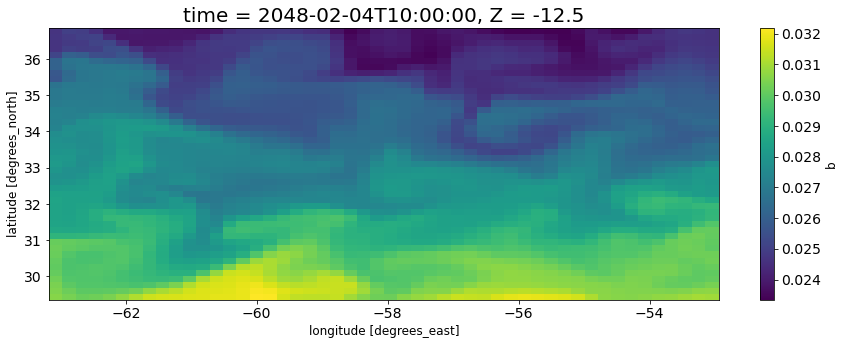

In [14]:
dsf['16km'].b.isel(time=20, Z=2).plot()

In [16]:
dsf['2km'].nbytes/(1024*1024*1024)

2186.4166647940874

In [19]:
%%time

Bp = {}

for r in ['16km','8km']:
    Bp[r] = xr.DataArray(dsf[r].b - dsf[r].b.mean(dim=['XC','YC']),
                       coords = {'time': dsf[r].time, 'Z' : grids2[r].Z, 'YC' : Y[r],'XC' : X[r]}, 
                       dims = ['time','Z','YC', 'XC'])

CPU times: user 1min 15s, sys: 26 s, total: 1min 41s
Wall time: 11min 19s


In [20]:
def azimuthal_avg(kidx, f, area, kr):
    iso = np.ma.masked_invalid(np.bincount(kidx, weights=f) / area) * kr
    return iso

def calc_isotropic_from_2d(kehat):
    data = kehat

    k = kehat.freq_XC.values
    l = kehat.freq_YC.values
    K = np.sqrt(k[np.newaxis,:]**2 + l[:,np.newaxis]**2)
    nfactor = 4
    nbins = int(min(len(k), len(l))/nfactor)
    if k.max() > l.max():
        ki = np.linspace(0., l.max(), nbins)
    else:
        ki = np.linspace(0., k.max(), nbins)
    kidx = np.digitize(np.ravel(K), ki)
    area = np.bincount(kidx)

    kr = np.bincount(kidx, weights=K.ravel()) / area
    if len(kehat.shape)== 2:

        f = kehat.data.reshape(kidx.shape)
        iso = azimuthal_avg(kidx,f,area,kr)

    elif len(kehat.shape) ==3:
        f= kehat.data.reshape((kehat.data.shape[0], kidx.shape[0]))
        iso = np.zeros((kehat.data.shape[0], kr.shape[0]))
        for j in range(kehat.data.shape[0]):
            iso[j] = azimuthal_avg(kidx,f[j],area,kr)



    elif len(kehat.shape) ==4:
        f= kehat.data.reshape((kehat.data.shape[0],kehat.data.shape[1], kidx.shape[0]))
        iso = np.zeros((kehat.data.shape[0], kehat.data.shape[1], kr.shape[0]))
        for j in range(kehat.data.shape[0]):
            for i in range(kehat.data.shape[1]):
                iso[j,i] = azimuthal_avg(kidx,f[j,i],area,kr)

    k_coords = {'freq_r': kr}

    newdims = [d for d in kehat.dims if d not in ['freq_XC', 'freq_YC']]
    newdims.append('freq_r')

    newcoords = {}
    for d in newdims:
        if d in kehat.coords:
            newcoords[d] = kehat.coords[d].values
        else:
            newcoords[d] = k_coords[d]
    keiso = xr.DataArray(iso, dims=newdims, coords=newcoords)

    return keiso

In [21]:
def calc_bp_spectra(ds, grids):
    grid = xgcm.Grid(grids, periodic=['X','Y','Z'])
    X = grid.interp(grids.dxG.cumsum(dim='XC'),'Y')
    Y = grid.interp(grids.dyG.cumsum(dim='YC'),'X')
    
    X = (X - X.mean(dim='XC')).mean(dim='YC').values
    Y = (Y - Y.mean(dim='YC')).mean(dim='XC').values
    
    Bp = xr.DataArray(ds.b - ds.b.mean(dim=['XC','YC']),
                       coords = {'time': ds.time, 'Z' : grids.Z, 'YC' : Y,'XC' : X}, 
                       dims = ['time','Z','YC', 'XC'])
    
    bphat = xrft.power_spectrum(Bp.isel(XC=slice(1,-1),YC=slice(1,-1)).sel(Z=slice(-5,-1000)).chunk({'time':1}), dim=['XC','YC'], window=True).compute()
    
    bphat_iso = calc_isotropic_from_2d(bphat).to_dataset(name='bphat_iso')

    return bphat_iso

In [23]:
%%time

ds_test = xr.open_dataset(indir_hf+'2km/2km_hourly_smalldomain_00022.nc')
bp_spec_test = calc_bp_spectra(ds_test, grids2['2km'])

/central/groups/oceanphysics/anirban/miniconda/envs/myenvironment2/lib/python3.7/site-packages/xrft/xrft.py:51: FutureWarning: Please provide the name of window adhering to scipy.signal.windows. The boolean option will be deprecated in future releases.
  FutureWarning,


CPU times: user 5.6 s, sys: 1.49 s, total: 7.09 s
Wall time: 3.2 s


/central/groups/oceanphysics/anirban/miniconda/envs/myenvironment2/lib/python3.7/site-packages/ipykernel_launcher.py:20: RuntimeWarning: invalid value encountered in true_divide
/central/groups/oceanphysics/anirban/miniconda/envs/myenvironment2/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in true_divide
  


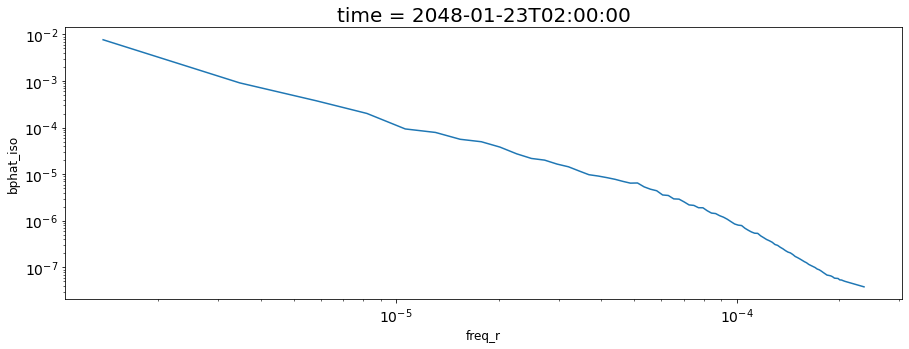

In [31]:
bp_spec_test.bphat_iso.sel(Z=slice(-5,-100)).mean(dim='Z')[0,1:].plot();plt.xscale('log');plt.yscale('log')

In [32]:
%%time
for j in range(731):
    clear_output(wait=True)
    calc_bp_spectra(xr.open_dataset(indir_hf+'2km/2km_hourly_smalldomain_%05d.nc' %j), grids2['2km']).to_netcdf(indir_hf + '2km/2km_bp_spectra_%05d.nc' %j)
    print('%s days' %(j+1))


/central/groups/oceanphysics/anirban/miniconda/envs/myenvironment2/lib/python3.7/site-packages/xrft/xrft.py:51: FutureWarning: Please provide the name of window adhering to scipy.signal.windows. The boolean option will be deprecated in future releases.
  FutureWarning,


731 days
CPU times: user 1h 7min 40s, sys: 18min 46s, total: 1h 26min 27s
Wall time: 35min 51s


/central/groups/oceanphysics/anirban/miniconda/envs/myenvironment2/lib/python3.7/site-packages/ipykernel_launcher.py:20: RuntimeWarning: invalid value encountered in true_divide
/central/groups/oceanphysics/anirban/miniconda/envs/myenvironment2/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in true_divide
  


In [33]:
%%time
for j in range(731):
    clear_output(wait=True)
    calc_bp_spectra(xr.open_dataset(indir_hf+'4km/4km_hourly_smalldomain_%05d.nc' %j), grids2['4km']).to_netcdf(indir_hf + '4km/4km_bp_spectra_%05d.nc' %j)
    print('%s days' %(j+1))


/central/groups/oceanphysics/anirban/miniconda/envs/myenvironment2/lib/python3.7/site-packages/xrft/xrft.py:51: FutureWarning: Please provide the name of window adhering to scipy.signal.windows. The boolean option will be deprecated in future releases.
  FutureWarning,


731 days
CPU times: user 21min 48s, sys: 2min 16s, total: 24min 5s
Wall time: 23min 58s


/central/groups/oceanphysics/anirban/miniconda/envs/myenvironment2/lib/python3.7/site-packages/ipykernel_launcher.py:20: RuntimeWarning: invalid value encountered in true_divide
/central/groups/oceanphysics/anirban/miniconda/envs/myenvironment2/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in true_divide
  


In [34]:
%%time
for j in range(731):
    clear_output(wait=True)
    calc_bp_spectra(xr.open_dataset(indir_hf+'8km/8km_hourly_smalldomain_%05d.nc' %j), grids2['8km']).to_netcdf(indir_hf + '8km/8km_bp_spectra_%05d.nc' %j)
    print('%s days' %(j+1))


731 days
CPU times: user 6min 1s, sys: 18.4 s, total: 6min 20s
Wall time: 9min 46s


/central/groups/oceanphysics/anirban/miniconda/envs/myenvironment2/lib/python3.7/site-packages/xrft/xrft.py:51: FutureWarning: Please provide the name of window adhering to scipy.signal.windows. The boolean option will be deprecated in future releases.
  FutureWarning,
/central/groups/oceanphysics/anirban/miniconda/envs/myenvironment2/lib/python3.7/site-packages/ipykernel_launcher.py:20: RuntimeWarning: invalid value encountered in true_divide
/central/groups/oceanphysics/anirban/miniconda/envs/myenvironment2/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in true_divide
  


In [35]:
%%time
for j in range(731):
    clear_output(wait=True)
    calc_bp_spectra(xr.open_dataset(indir_hf+'16km/16km_hourly_smalldomain_%05d.nc' %j), grids2['16km']).to_netcdf(indir_hf + '16km/16km_bp_spectra_%05d.nc' %j)
    print('%s days' %(j+1))


731 days
CPU times: user 3min 51s, sys: 8.64 s, total: 4min
Wall time: 9min 44s


/central/groups/oceanphysics/anirban/miniconda/envs/myenvironment2/lib/python3.7/site-packages/xrft/xrft.py:51: FutureWarning: Please provide the name of window adhering to scipy.signal.windows. The boolean option will be deprecated in future releases.
  FutureWarning,
/central/groups/oceanphysics/anirban/miniconda/envs/myenvironment2/lib/python3.7/site-packages/ipykernel_launcher.py:20: RuntimeWarning: invalid value encountered in true_divide
/central/groups/oceanphysics/anirban/miniconda/envs/myenvironment2/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in true_divide
  


In [37]:
ds_test

<xarray.Dataset>
Dimensions:   (time: 6, Z: 58, YG: 360, XC: 400, YC: 360, XG: 400, Zl: 58)
Coordinates:
  * time      (time) datetime64[ns] 2048-01-23T02:00:00 ... 2048-01-23T22:00:00
  * Z         (Z) float32 -2.5 -7.5 -12.5 -17.5 ... -933.8 -982.5 -1.032e+03
  * YG        (YG) float32 29.36 29.38 29.4 29.42 ... 36.77 36.79 36.81 36.83
  * XC        (XC) float32 -63.16 -63.14 -63.11 -63.08 ... -53.01 -52.98 -52.96
  * YC        (YC) float32 29.37 29.39 29.41 29.43 ... 36.78 36.8 36.82 36.84
  * XG        (XG) float32 -63.17 -63.15 -63.12 -63.1 ... -53.02 -53.0 -52.97
  * Zl        (Zl) float32 0.0 -5.0 -10.0 -15.0 ... -909.5 -958.0 -1.007e+03
Data variables: (12/15)
    v         (time, Z, YG, XC) float32 ...
    u         (time, Z, YC, XG) float32 ...
    w         (time, Zl, YC, XC) float32 ...
    theta     (time, Z, YC, XC) float32 ...
    salt      (time, Z, YC, XC) float32 ...
    b         (time, Z, YC, XC) float64 0.03095 0.03122 ... 0.01397 0.01397
    ...        ...
    ADVx_TH   (time, Z, YC, XG) float32 ...
    ADVy_TH   (time, Z, YG, XC) float32 ...
    ADVx_SLT  (time, Z, YC, XG) float32 ...
    ADVy_SLT  (time, Z, YG, XC) float32 ...
    PHIHYD    (time, Z, YC, XC) float32 ...
    KPPvisc   (time, Zl, YC, XC) float32 ...

In [39]:
ds_test.theta.coords

Coordinates:
  * time     (time) datetime64[ns] 2048-01-23T02:00:00 ... 2048-01-23T22:00:00
  * Z        (Z) float32 -2.5 -7.5 -12.5 -17.5 ... -933.8 -982.5 -1.032e+03
  * XC       (XC) float32 -63.16 -63.14 -63.11 -63.08 ... -53.01 -52.98 -52.96
  * YC       (YC) float32 29.37 29.39 29.41 29.43 ... 36.78 36.8 36.82 36.84

In [42]:
grids2['2km'].rAz

<xarray.DataArray 'rAz' (YG: 360, XG: 400)>
dask.array<getitem, shape=(360, 400), dtype=>f4, chunksize=(360, 400), chunktype=numpy.ndarray>
Coordinates:
  * XG       (XG) >f4 -63.17 -63.15 -63.12 -63.1 ... -53.05 -53.02 -53.0 -52.97
  * YG       (YG) >f4 29.36 29.38 29.4 29.42 29.44 ... 36.77 36.79 36.81 36.83
    rAz      (YG, XG) >f4 dask.array<chunksize=(360, 400), meta=np.ndarray>
Attributes:
    standard_name:  cell_area_at_f_location
    long_name:      cell area
    units:          m
    coordinate:     YG XG

In [41]:
grids2['2km']

<xarray.Dataset>
Dimensions:  (XC: 400, YC: 360, XG: 400, YG: 360, Z: 58, Zu: 58, Zl: 58, Zp1: 58)
Coordinates: (12/30)
  * XC       (XC) >f4 -63.16 -63.14 -63.11 -63.08 ... -53.01 -52.98 -52.96
  * YC       (YC) >f4 29.37 29.39 29.41 29.43 29.45 ... 36.78 36.8 36.82 36.84
  * XG       (XG) >f4 -63.17 -63.15 -63.12 -63.1 ... -53.05 -53.02 -53.0 -52.97
  * YG       (YG) >f4 29.36 29.38 29.4 29.42 29.44 ... 36.77 36.79 36.81 36.83
  * Z        (Z) >f4 -2.5 -7.5 -12.5 -17.5 ... -885.5 -933.8 -982.5 -1.032e+03
  * Zu       (Zu) >f4 -5.0 -10.0 -15.0 -20.0 ... -958.0 -1.007e+03 -1.056e+03
    ...       ...
    maskW    (Z, YC, XG) bool dask.array<chunksize=(58, 360, 400), meta=np.ndarray>
    maskS    (Z, YG, XC) bool dask.array<chunksize=(58, 360, 400), meta=np.ndarray>
    maskInC  (YC, XC) bool dask.array<chunksize=(360, 400), meta=np.ndarray>
    maskInS  (YG, XC) bool dask.array<chunksize=(360, 400), meta=np.ndarray>
    rhoRef   (Z) >f4 1.025e+03 1.025e+03 1.025e+03 ... 1.032e+03 1.032e+03
    maskInW  (YC, XG) bool dask.array<chunksize=(360, 400), meta=np.ndarray>
Dimensions without coordinates: Zp1
Data variables:
    *empty*
Attributes:
    Conventions:  CF-1.6
    title:        netCDF wrapper of MITgcm MDS binary data
    source:       MITgcm
    history:      Created by calling `open_mdsdataset(grid_dir=None, iters=No...

In [56]:
def modewater_pv(ds, grids):
    ds['ZC'] = xr.DataArray(grids.Z.values[np.newaxis,:,np.newaxis,np.newaxis]*ones_like(ds.theta.data),
                            dims=ds.theta.dims,
                            coords=ds.theta.coords)
    grid = xgcm.Grid(grids, periodic=['X', 'Y', 'Z'])
    B_y = (grid.interp(grid.diff(ds.b.where(grids.hFacC),'Y')/grids.dyC, 'Y'))
    B_x = (grid.interp(grid.diff(ds.b.where(grids.hFacC),'X')/grids.dxC, 'X'))
    B_z = (grid.interp(grid.diff(ds.b.where(grids.hFacC),'Z')/(grid.diff(ds.Z,'Z')),'Z'))
    
    f = xr.DataArray(2 * 7.2921e-5 * np.sin(np.radians(ds.YC.values))[np.newaxis, 
                                                                         np.newaxis, :, 
                                                                         np.newaxis]*ones_like(ds.theta.data), 
                     coords = ds.theta.coords, dims = ds.theta.dims)
    
    
    dudy = grid.interp(grid.interp(grid.diff(ds.u*grids.hFacW, 'Y')/grid.interp(grids.dyC, 'X'),'X'),'Y')
    dudz = grid.interp(grid.interp(grid.diff(ds.u*grids.hFacW, 'Z')/(grid.diff(ds.Z,'Z')),'Z'), 'X')
    dvdx = grid.interp(grid.interp(grid.diff(ds.v*grids.hFacS, 'X')/grid.interp(grids.dxC, 'Y'),'X'),'Y')
    dvdz = grid.interp(grid.interp(grid.diff(ds.v*grids.hFacS, 'Z')/(grid.diff(ds.Z,'Z')),'Z'), 'Y')
    dwdx = grid.interp(grid.interp(grid.diff(ds.w, 'X')/grids.dxC, 'Z')*grids.hFacW, 'X')
    dwdy = grid.interp(grid.interp(grid.diff(ds.w, 'Y')/grids.dyC, 'Z')*grids.hFacS, 'Y')
#     omega_a = 
#     gradb = 
    PV = (dwdy - dvdz)* B_x - (dwdx - dudz)* B_y + (dvdx - dudy + f)* B_z
    
    fbz = f*B_z
    
    fbz_mw = fbz.where(grids.hFacC).where((ds.theta>17) &(ds.theta<19)).isel(XC=slice(1,-1),YC=slice(1,-1)).sel(Z=slice(-5,-1000)).mean(dim='Z')
    PV_mw = PV.where(grids.hFacC).where((ds.theta>17) &(ds.theta<19)).isel(XC=slice(1,-1),YC=slice(1,-1)).sel(Z=slice(-5,-1000)).mean(dim='Z')
    
    mw = xr.merge([fbz_mw.to_dataset(name='fbz_mw'), PV_mw.to_dataset(name='PV_mw')])
    
 
    return mw


In [57]:
%%time

ds_test = xr.open_dataset(indir_hf+'2km/2km_hourly_smalldomain_00300.nc')
mwpvtest = modewater_pv(ds_test, grids2['2km'])

CPU times: user 5.29 s, sys: 1.13 s, total: 6.43 s
Wall time: 7.68 s


In [58]:
%%time
for j in range(731):
    clear_output(wait=True)
    modewater_pv(xr.open_dataset(indir_hf+'2km/2km_hourly_smalldomain_%05d.nc' %j), grids2['2km']).to_netcdf(indir_hf + '2km/2km_pv_modewater_%05d.nc' %j)
    print('%s days' %(j+1))


/central/groups/oceanphysics/anirban/miniconda/envs/myenvironment2/lib/python3.7/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


731 days
CPU times: user 2h 12min 31s, sys: 1h 6min 29s, total: 3h 19min
Wall time: 2h 6min 11s


In [59]:
%%time
for j in range(731):
    clear_output(wait=True)
    modewater_pv(xr.open_dataset(indir_hf+'4km/4km_hourly_smalldomain_%05d.nc' %j), grids2['4km']).to_netcdf(indir_hf + '4km/4km_pv_modewater_%05d.nc' %j)
    print('%s days' %(j+1))


731 days
CPU times: user 37min 27s, sys: 14min 19s, total: 51min 46s
Wall time: 42min 50s


In [60]:
%%time
for j in range(731):
    clear_output(wait=True)
    modewater_pv(xr.open_dataset(indir_hf+'8km/8km_hourly_smalldomain_%05d.nc' %j), grids2['8km']).to_netcdf(indir_hf + '8km/8km_pv_modewater_%05d.nc' %j)
    print('%s days' %(j+1))


731 days
CPU times: user 15min 35s, sys: 2min 2s, total: 17min 38s
Wall time: 22min 44s


In [61]:
%%time
for j in range(731):
    clear_output(wait=True)
    modewater_pv(xr.open_dataset(indir_hf+'16km/16km_hourly_smalldomain_%05d.nc' %j), grids2['16km']).to_netcdf(indir_hf + '16km/16km_pv_modewater_%05d.nc' %j)
    print('%s days' %(j+1))


731 days
CPU times: user 6min 48s, sys: 25.4 s, total: 7min 13s
Wall time: 9min 18s


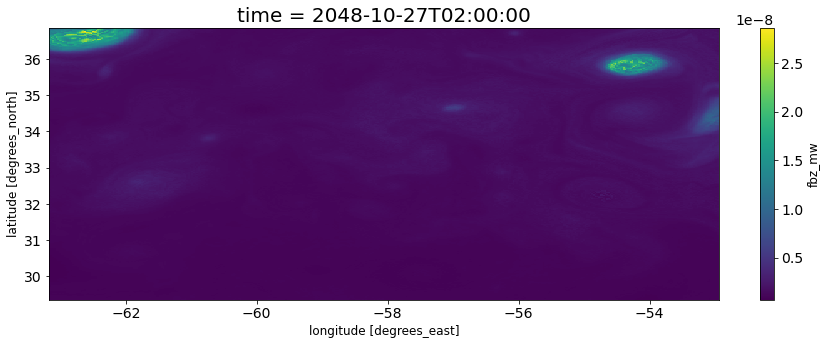

In [54]:
mwpvtest.fbz_mw.isel(time=0).plot()

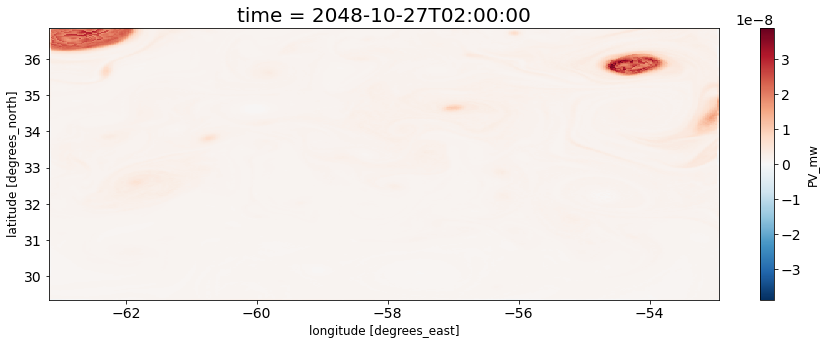

In [55]:
mwpvtest.PV_mw.isel(time=0).plot()

In [ ]:
def calc_gradb(ds2, grids2):
    grid = xgcm.Grid(grids2, periodic=['X','Y','Z'])
    X = grid.interp(grids2.dxG.cumsum(dim='XC'),'Y')
    Y = grid.interp(grids2.dyG.cumsum(dim='YC'),'X')
    
    X = (X - X.mean(dim='XC')).mean(dim='YC').values
    Y = (Y - Y.mean(dim='YC')).mean(dim='XC').values
    
    nx = len(ds2.XC)
    ny = len(ds2.YC)
    
    b_y = xr.DataArray((grid.interp(grid.diff(ds2.b, 'Y')/grids2.dyC, 'Y')),
                       coords = {'time': ds2.time, 'Z' : grids2.Z, 'YC' : Y,'XC' : X}, 
                       dims = ['time','Z','YC', 'XC'])
    b_x = xr.DataArray((grid.interp(grid.diff(ds2.b, 'X')/grids2.dxC, 'X')),
                       coords = {'time': ds2.time, 'Z' : grids2.Z, 'YC' : Y,'XC' : X}, 
                       dims = ['time','Z','YC', 'XC'])
                       
#     mxld = xr.DataArray(ds2.MXLDEPTH,
#                        coords = {'time': ds2.time, 'YC' : Y,'XC' : X}, 
#                        dims = ['time','YC', 'XC'])
    
    
    ds_bxy = xr.merge([b_y.isel(XC=slice(1,-1),YC=slice(1,-1)).sel(Z=slice(-5,-1000)).to_dataset(name='b_y'), 
                      b_x.isel(XC=slice(1,-1),YC=slice(1,-1)).sel(Z=slice(-5,-1000)).to_dataset(name='b_x'), 
                     ])

    return ds_bxy